In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 224, 224, 3)
[1 0 0 1 1 0 0 1]


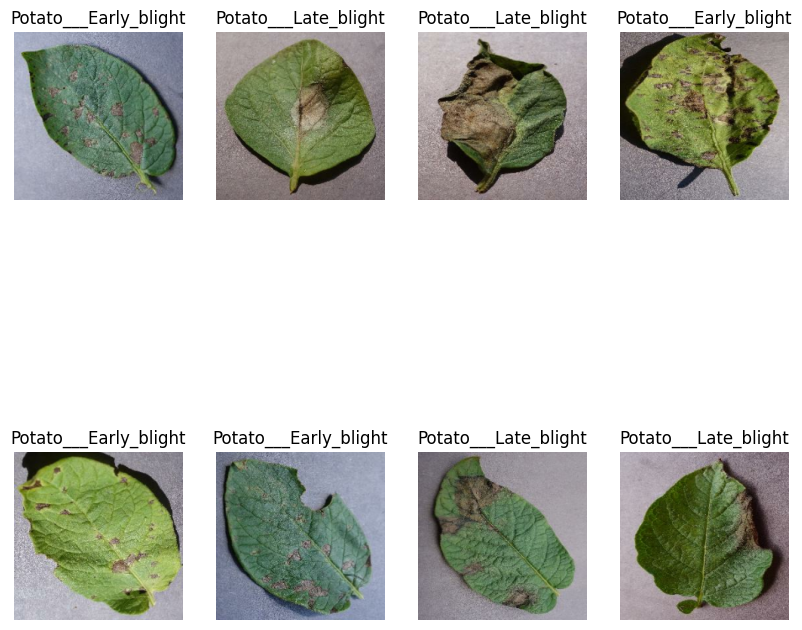

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
from tensorflow.keras.applications import DenseNet121

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 7,563,843
Trainable params: 526,339
Non-trainable params: 7,037,504
______________________________________

In [ ]:
model.compile(
    optimizer='sgd',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 35s 89ms/step - loss: 6.6909 - accuracy: 0.9079 - val_loss: 6.1534 - val_accuracy: 0.9831
Epoch 2/50
300/300 [==============================] - 24s 81ms/step - loss: 5.8095 - accuracy: 0.9754 - val_loss: 5.4423 - val_accuracy: 0.9831
Epoch 3/50
300/300 [==============================] - 24s 82ms/step - loss: 5.1422 - accuracy: 0.9829 - val_loss: 4.8749 - val_accuracy: 0.9595
Epoch 4/50
300/300 [==============================] - 25s 84ms/step - loss: 4.5626 - accuracy: 0.9842 - val_loss: 4.3066 - val_accuracy: 0.9797
Epoch 5/50
300/300 [==============================] - 25s 85ms/step - loss: 4.0453 - accuracy: 0.9887 - val_loss: 3.8162 - val_accuracy: 0.9831
Epoch 6/50
300/300 [==============================] - 26s 85ms/step - loss: 3.5937 - accuracy: 0.9900 - val_loss: 3.4020 - val_accuracy: 0.9764
Epoch 7/50
300/300 [==============================] - 25s 83ms/step - loss: 3.1909 - accuracy: 0.9912 - val_loss: 3.0170 - val_accuracy:

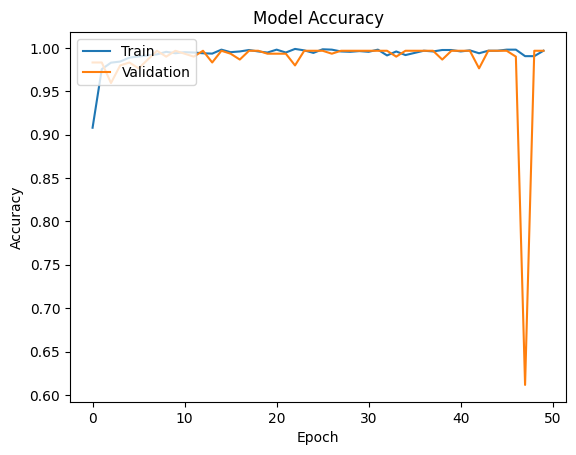

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

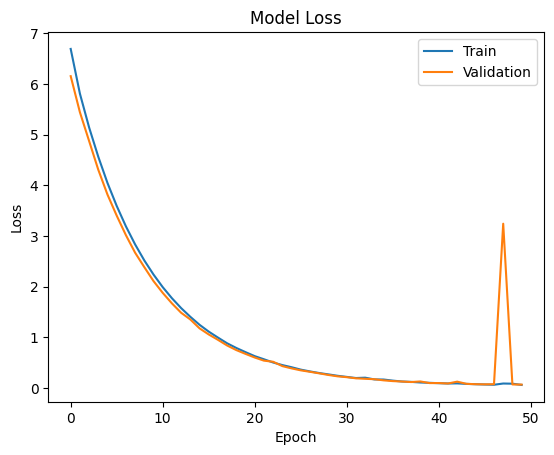

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

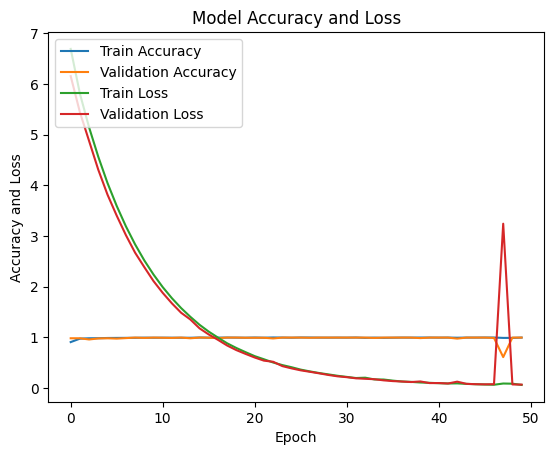

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 8s 88ms/step - loss: 0.0568 - accuracy: 1.0000


[0.9079166650772095,
 0.9754166603088379,
 0.9829166531562805,
 0.98416668176651,
 0.9887499809265137,
 0.9900000095367432,
 0.9912499785423279,
 0.9925000071525574,
 0.9954166412353516,
 0.9937499761581421,
 0.9950000047683716,
 0.9945833086967468,
 0.9937499761581421,
 0.9933333396911621,
 0.9979166388511658,
 0.9950000047683716,
 0.9958333373069763,
 0.9975000023841858,
 0.9958333373069763,
 0.9945833086967468,
 0.9979166388511658,
 0.9945833086967468,
 0.9987499713897705,
 0.997083306312561,
 0.9941666722297668,
 0.9983333349227905,
 0.9979166388511658,
 0.9958333373069763,
 0.9954166412353516,
 0.9962499737739563,
 0.9954166412353516,
 0.9979166388511658,
 0.9912499785423279,
 0.9958333373069763,
 0.9916666746139526,
 0.9941666722297668,
 0.996666669845581,
 0.9958333373069763,
 0.9975000023841858,
 0.9975000023841858,
 0.9958333373069763,
 0.997083306312561,
 0.9937499761581421,
 0.996666669845581,
 0.996666669845581,
 0.9979166388511658,
 0.9979166388511658,
 0.9904166460037231,

In [ ]:
history.history['val_accuracy']

[0.9831081032752991,
 0.9831081032752991,
 0.9594594836235046,
 0.9797297120094299,
 0.9831081032752991,
 0.9763513803482056,
 0.9864864945411682,
 0.9966216087341309,
 0.9898648858070374,
 0.9966216087341309,
 0.9932432174682617,
 0.9898648858070374,
 0.9966216087341309,
 0.9831081032752991,
 0.9966216087341309,
 0.9932432174682617,
 0.9864864945411682,
 0.9966216087341309,
 0.9966216087341309,
 0.9932432174682617,
 0.9932432174682617,
 0.9932432174682617,
 0.9797297120094299,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9932432174682617,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9898648858070374,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9864864945411682,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9763513803482056,
 0.9966216087341309,
 0.9966216087341309,
 0.9966216087341309,
 0.9898648858070374,
 0.6114864945

In [ ]:
history.history['loss']

[6.690910339355469,
 5.809510707855225,
 5.142220497131348,
 4.562556266784668,
 4.045338153839111,
 3.5936567783355713,
 3.1909379959106445,
 2.834718942642212,
 2.518616199493408,
 2.240140199661255,
 1.9918057918548584,
 1.773085117340088,
 1.5783849954605103,
 1.4067963361740112,
 1.2490180730819702,
 1.1141576766967773,
 0.9968984723091125,
 0.8838820457458496,
 0.7915082573890686,
 0.7093220949172974,
 0.6304260492324829,
 0.568954586982727,
 0.5050927996635437,
 0.45416849851608276,
 0.4120675027370453,
 0.3647076487541199,
 0.3290395140647888,
 0.2976262867450714,
 0.27061840891838074,
 0.24319295585155487,
 0.22094205021858215,
 0.19885437190532684,
 0.2056695967912674,
 0.17132148146629333,
 0.16945715248584747,
 0.14757031202316284,
 0.13007549941539764,
 0.12256581336259842,
 0.11065182089805603,
 0.10408741980791092,
 0.09700772911310196,
 0.09097202867269516,
 0.09310158342123032,
 0.08323954790830612,
 0.07656551897525787,
 0.07112836092710495,
 0.06613858044147491,
 0.0

In [ ]:
history.history['val_loss']

[6.15341329574585,
 5.442309379577637,
 4.874853610992432,
 4.306581020355225,
 3.8161637783050537,
 3.402019500732422,
 3.016986846923828,
 2.6707842350006104,
 2.386132001876831,
 2.1110024452209473,
 1.8787654638290405,
 1.6714805364608765,
 1.4864078760147095,
 1.3541895151138306,
 1.1790779829025269,
 1.0582307577133179,
 0.9525977373123169,
 0.8405470848083496,
 0.7498491406440735,
 0.6749129891395569,
 0.6033658385276794,
 0.541718602180481,
 0.5196016430854797,
 0.4339437782764435,
 0.38913506269454956,
 0.35045504570007324,
 0.32167699933052063,
 0.2913341522216797,
 0.2595127820968628,
 0.23235465586185455,
 0.21571850776672363,
 0.19311769306659698,
 0.18378931283950806,
 0.17547515034675598,
 0.1531398743391037,
 0.1382700502872467,
 0.1298942267894745,
 0.11962451040744781,
 0.1312914788722992,
 0.09909921139478683,
 0.09986045211553574,
 0.0907212346792221,
 0.12722542881965637,
 0.084550641477108,
 0.07705371081829071,
 0.07413037121295929,
 0.07709573954343796,
 3.24308

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  1.0
Loss:  0.056768517941236496


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

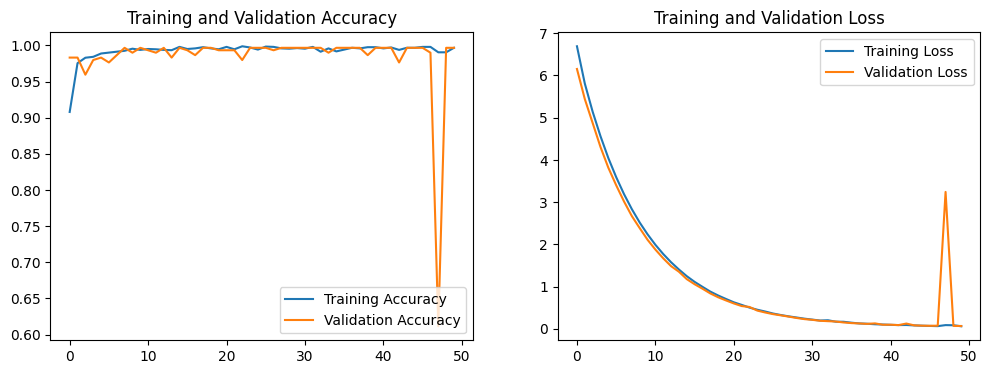

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 5s 5s/step
[2.2330294e-05 9.9997687e-01 8.2032335e-07]
Max Value: 1
Predicted Label: Potato___Late_blight


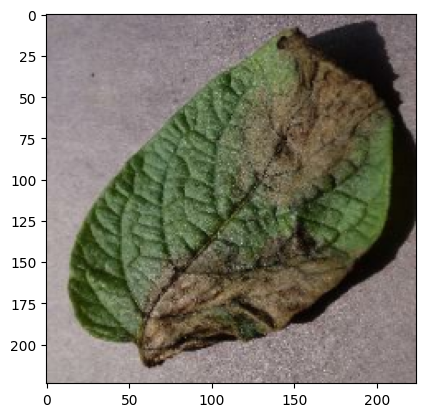

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


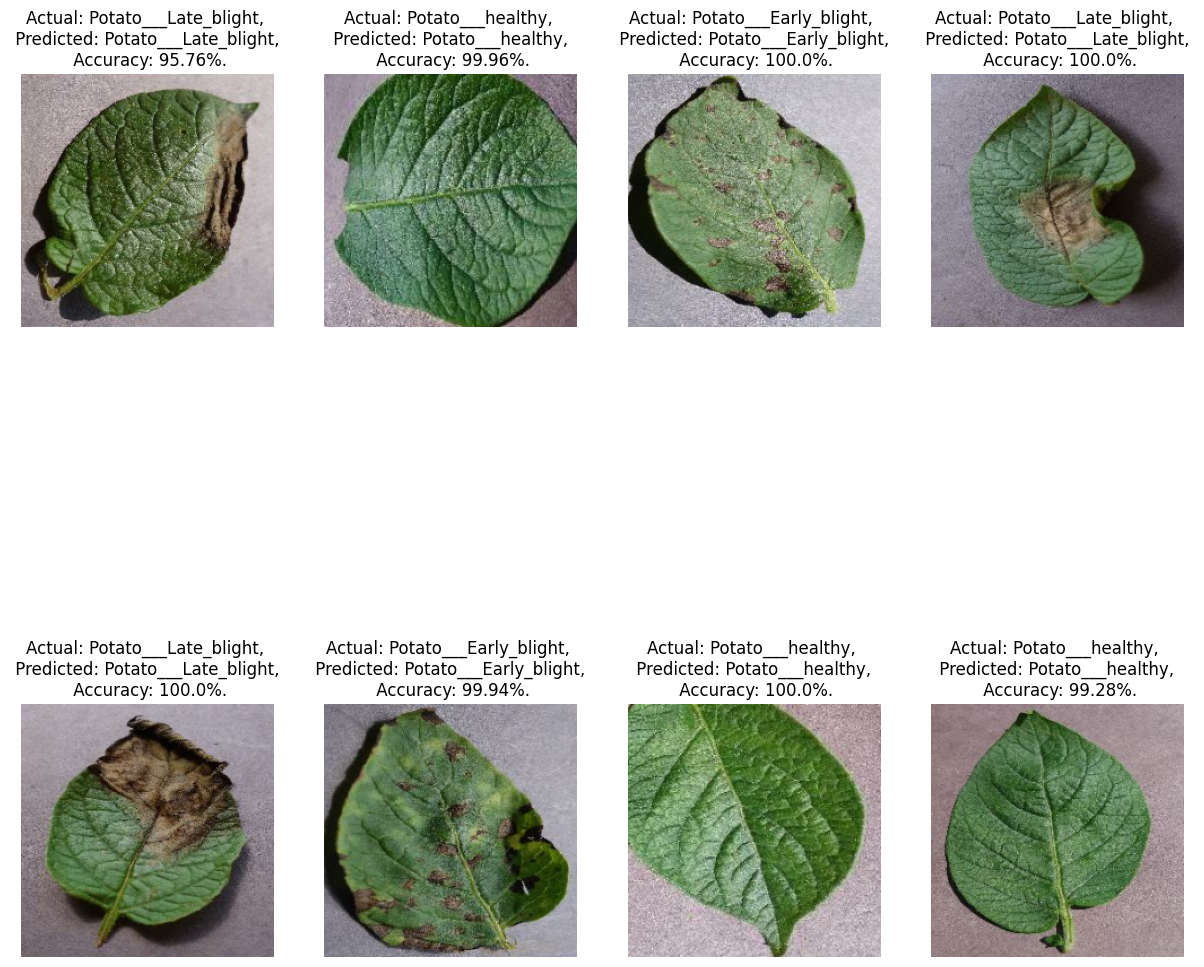

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  100.0


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 8s 78ms/step
F1 Score:  30.92105263157895
Precision Score:  30.92105263157895
Recall Score:  30.92105263157895


38/38 [==============================] - 3s 76ms/step


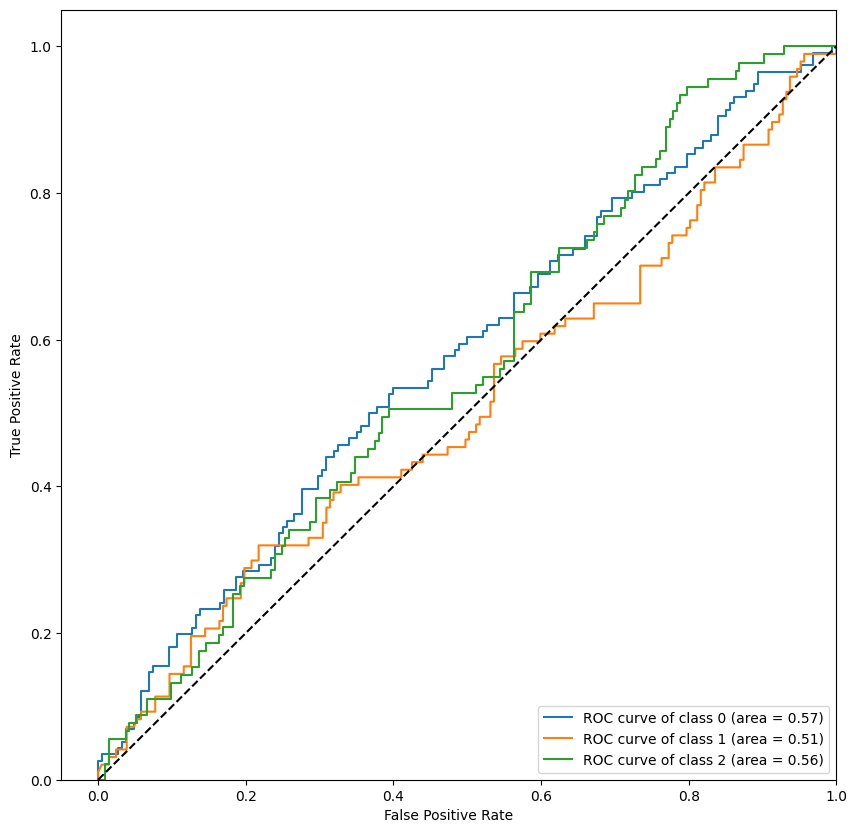

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 75ms/step


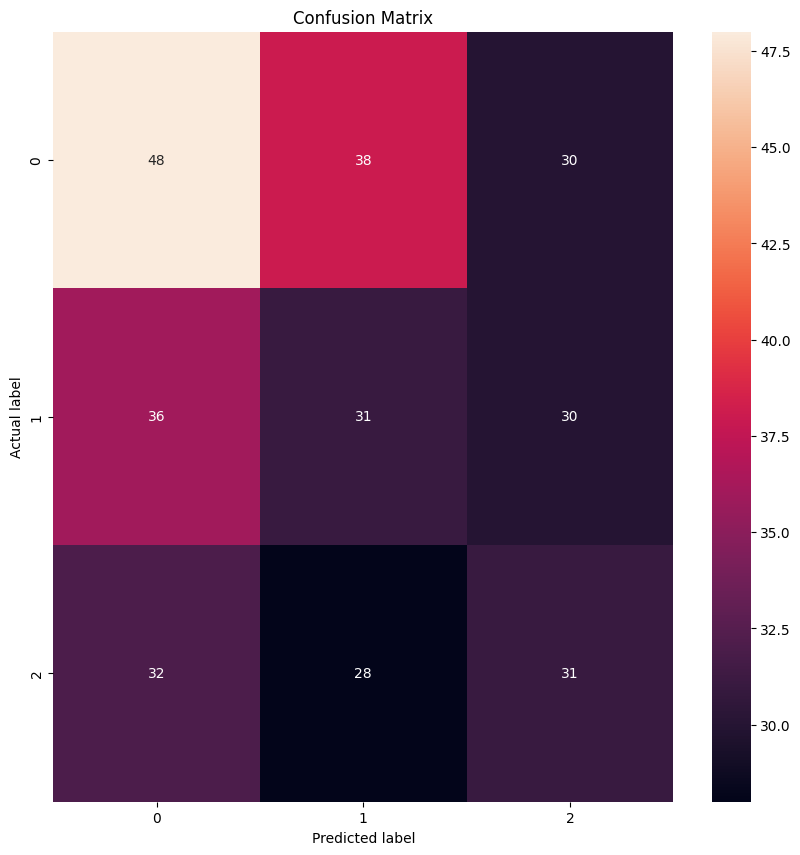

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()